In [68]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import math
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization
import cv2
import keras
from keras_cv import models, losses, callbacks
import keras_cv.losses as losses
from keras_cv.models import YOLOV8Detector
import matplotlib.patches as patches
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Data Input Pipeline

In [70]:
IMAGE_SIZE = (640, 640)  # Input size for YOLOv8
BATCH_SIZE = 3  # Number of samples per batch
NUM_CLASSES = 1  # Example number of classes, adjust as needed
BOUNDING_BOX_FORMAT = "xywh"  # YOLO bounding box format
PAD_TO_ASPECT_RATIO = True  # To maintain aspect ratio when resizing

In [71]:
# Paths to the datasets
TRAIN_IMAGES_DIR = Path("dataset/train/images/")
TRAIN_LABELS_DIR = Path("dataset/train/labels/")

VAL_IMAGES_DIR = Path("dataset/val/images/")
VAL_LABELS_DIR = Path("dataset/val/labels/")

In [72]:
# Function to load YOLO annotations
def load_yolo_annotations(label_path, image_size):
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            if len(parts) != 5:
                continue  # Skip lines that don't match expected format

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert normalized "xywh" to pixel-based "xyxy" format
            x_min = (x_center - width / 2) * image_size[0]
            y_min = (y_center - height / 2) * image_size[1]
            x_max = (x_center + width / 2) * image_size[0]
            y_max = (y_center + height / 2) * image_size[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [73]:
# Function to load image and corresponding annotations
def load_sample(image_path, labels_dir):
    image_path_str = tf.keras.backend.get_value(image_path).decode("utf-8")  # Convert tensor to string
    image = Image.open(image_path_str).resize(IMAGE_SIZE)  # Resize to 640x640
    image = np.array(image) / 255.0  # Normalize
    
    # Construct the label path and validate its existence
    image_stem = Path(image_path_str).stem
    label_path = os.path.join(labels_dir, image_stem + ".txt")

    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    # Load YOLO annotations
    annotations = load_yolo_annotations(label_path, IMAGE_SIZE)  # Load annotations
    return image, annotations

In [108]:
# Function to resize image for inference
def inference_resizing(image, annotations):
    resized_image = tf.image.resize(image, [640, 640])
    return resized_image, annotations

In [109]:
# Function to count elements in a dataset
def count_elements(dataset):
    return dataset.cardinality().numpy()

# Check if the dataset is empty
def is_dataset_empty(dataset):
    return count_elements(dataset) <= 0

In [110]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [111]:
# Function to normalize image data
def normalize_image_data(image):
    # Convert TensorFlow tensor to NumPy array
    image = image.numpy()  # Explicit conversion
    # If data is in float format, scale to [0, 255]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    return image

In [112]:
# Function to convert from BGR to RGB if needed
def ensure_rgb_format(image):
    # If the image appears incorrect, try converting BGR to RGB
    if image.shape[-1] == 3:  # Assuming three channels (RGB or BGR)
        return image[..., ::-1]  # Reverse the color channels to convert BGR to RGB
    return image


In [113]:
# Function to filter out empty annotations
def filter_empty_annotations(image, annotations):
  return tf.size(annotations) > 0  # Check if there are any annotations

In [114]:
def pad_annotations(image, annotations, max_annotations=5):
    num_annotations = tf.shape(annotations)[0]
    annotations = tf.reshape(annotations, [num_annotations, 5])

    padding = [[0, max_annotations - num_annotations], [0, 0]]
    annotations = tf.pad(annotations, padding, constant_values=-1)

    boxes = annotations[:, :4]
    classes = tf.expand_dims(annotations[:, 4], axis=-1)
    
    return image, {'boxes': boxes, 'classes': classes}

In [141]:
def data_loader(images_dir, labels_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg")) + list(Path(images_dir).rglob("*.png"))

    if len(image_paths) == 0:
        raise ValueError(f"No images found in {images_dir}. Check your dataset path.")

    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    def load_sample_with_shape(image_path):
        image, annotations = tf.py_function(
            lambda y: load_sample(y, labels_dir),
            [image_path],
            [tf.float32, tf.float32]
        )
        image.set_shape(IMAGE_SIZE + (3,))
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(load_sample_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # def resize_with_shape(image, annotations):
    #     image, annotations = tf.py_function(
    #         func=lambda img, ann: inference_resizing(img, ann),
    #         inp=[image, annotations],
    #         Tout=[tf.float32, tf.float32]
    #     )
    #     image.set_shape([640, 640, 3])
    #     annotations.set_shape([None, 5])
    #     return image, annotations

    # dataset = dataset.map(resize_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # def normalize_with_shape(image, annotations):
    #     image, annotations = tf.py_function(
    #         func=lambda img, ann: (normalize_image_data(img), ann),
    #         inp=[image, annotations],
    #         Tout=[tf.float32, tf.float32]
    #     )
    #     image.set_shape([640, 640, 3])
    #     annotations.set_shape([None, 5])
    #     return image, annotations

    # dataset = dataset.map(normalize_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # def ensure_rgb_with_shape(image, annotations):
    #     image, annotations = tf.py_function(
    #         func=lambda img, ann: (ensure_rgb_format(img), ann),
    #         inp=[image, annotations],
    #         Tout=[tf.float32, tf.float32]
    #     )
    #     image.set_shape([640, 640, 3])
    #     annotations.set_shape([None, 5])
    #     return image, annotations

    # dataset = dataset.map(ensure_rgb_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.filter(lambda image, annotations: tf.py_function(
        func=filter_empty_annotations,
        inp=[image, annotations],
        Tout=tf.bool)
    )

    dataset = dataset.map(lambda image, annotations: pad_annotations(image, annotations))

    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset

In [142]:
# Create datasets for training, validation, and testing
train_dataset = data_loader(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, BATCH_SIZE)
val_dataset = data_loader(VAL_IMAGES_DIR, VAL_LABELS_DIR, BATCH_SIZE // 2)

## Visualization

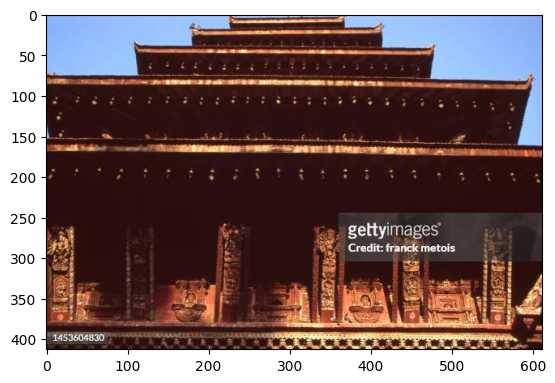

In [143]:
%matplotlib inline
img = Image.open(Path("D:/Projects/DL/MonumentDetection/DL/dataset/train/images/1c2822e4-image_480.png"))
img = np.asarray(img)
imgplot = plt.imshow(img)

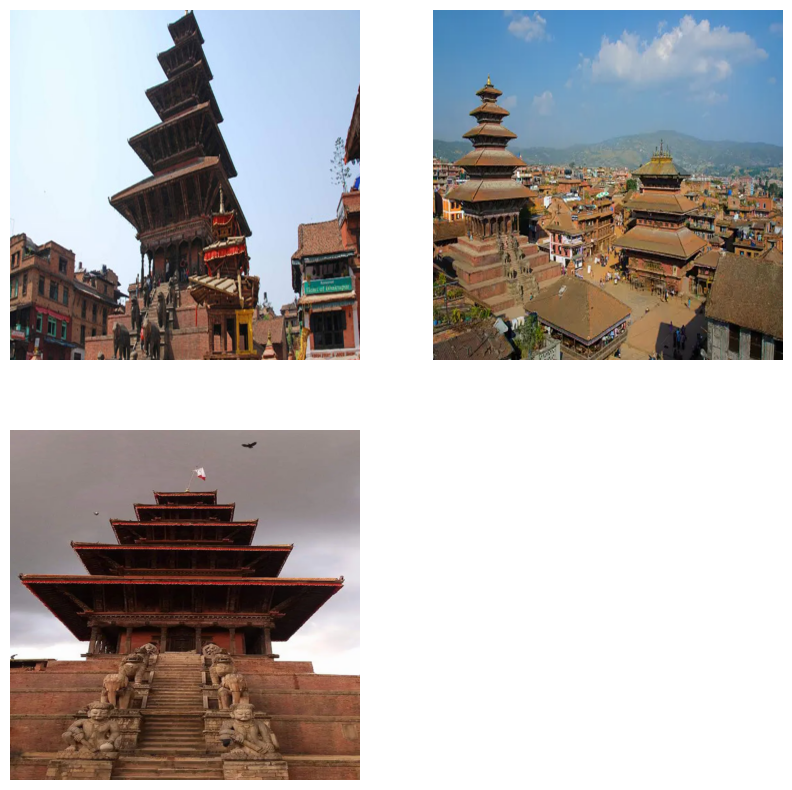

In [144]:
for batch in train_dataset.take(1):  # Take the first batch
    images = batch[0]  # Assuming images are the first element
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(2, 2, i + 1)  # Assuming only 1 image in the batch
        plt.imshow(image.numpy())
        plt.axis('off')
    plt.show()

In [145]:
iterator = iter(train_dataset)
batch = next(iterator)  # Get the next batch

images, annotations = batch  # Assuming images are first, annotations are second

print(annotations)

{'boxes': <tf.Tensor: shape=(3, 5, 4), dtype=float32, numpy=
array([[[179.3936 ,   3.87872, 432.4848 , 864.9699 ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[ 22.63264, 113.6096 , 226.32608, 340.8288 ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[ 24.66016,   4.66624, 573.064  , 325.33313],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]]], dtype=float32)>, 'classes': <tf.Tensor: shape=(3, 5, 1), dtype=float32, numpy=
array([[[ 0.],
        [-1.],
        [-1.],

Image shape: (640, 640, 3)
Number of valid boxes: 1
Valid boxes: [[179.3936    3.87872 432.4848  864.9699 ]]
Valid classes: [[0.]]
Image shape: (640, 640, 3)
Number of valid boxes: 1
Valid boxes: [[ 22.63264 113.6096  226.32608 340.8288 ]]
Valid classes: [[0.]]
Image shape: (640, 640, 3)
Number of valid boxes: 1
Valid boxes: [[ 24.66016   4.66624 573.064   325.33313]]
Valid classes: [[0.]]


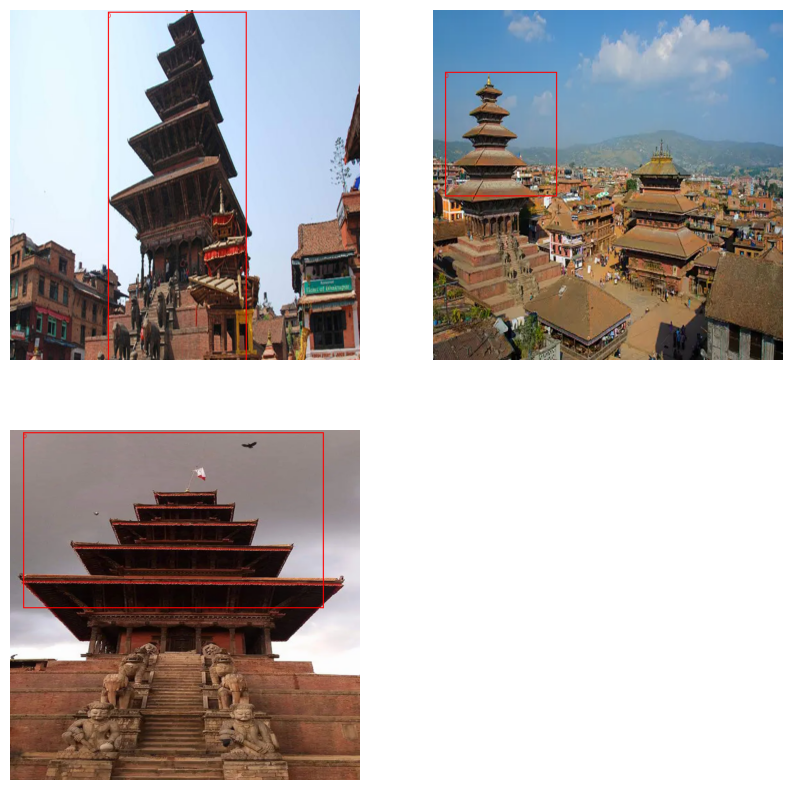

In [161]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tensorflow as tf

def visualize_image_with_bboxes(image, boxes, class_labels, bbox_color='red', bbox_width=2):
    """
    Visualize an image with bounding boxes and class labels.
    
    Parameters:
    - image: Tensor image.
    - boxes: List of bounding boxes.
    - class_labels: List of class labels corresponding to bounding boxes.
    - bbox_color: Color of the bounding box.
    - bbox_width: Width of the bounding box line.
    """
    # Convert Tensor image to PIL Image
    image_np = (image.numpy() * 255).astype('uint8')
    image_pil = Image.fromarray(image_np)
    draw = ImageDraw.Draw(image_pil)

    for box, label in zip(boxes, class_labels):
        xmin, ymin, xmax, ymax = box.numpy()
        
        if (ymax - ymin) > 0 and (xmax - xmin) > 0:
            draw.rectangle([xmin, ymin, xmax, ymax], outline=bbox_color, width=bbox_width)
            draw.text((xmin, ymin), str(int(label.numpy()[0])), fill=bbox_color)

    return image_pil

for batch in train_dataset.take(1):
    images = batch[0]
    ground_truths = batch[1]
    plt.figure(figsize=(10, 10))
    boxes = ground_truths['boxes']
    class_labels = ground_truths['classes']

    for i, (image, box, class_label) in enumerate(zip(images, boxes, class_labels)):
        plt.subplot(2, 2, i + 1)
        print(f"Image shape: {image.shape}")

        # Filter out invalid boxes
        valid_indices = tf.where(box[:, 2] > 0)
        valid_boxes = tf.gather_nd(box, valid_indices)
        valid_classes = tf.gather_nd(class_label, valid_indices)
        num_valid_boxes = valid_boxes.shape[0]

        print(f"Number of valid boxes: {num_valid_boxes}")
        print(f"Valid boxes: {valid_boxes.numpy()}")
        print(f"Valid classes: {valid_classes.numpy()}")

        image_with_bboxes = visualize_image_with_bboxes(image, valid_boxes, valid_classes)
        plt.imshow(image_with_bboxes)
        plt.axis("off")
        
    plt.show()
